# 

In [2]:
import numpy as np
import pandas as pd
import yaml
import torch
from torch import nn
import scanpy as sc

from celldreamer.data.scrnaseq_loader import RNAseqLoader
from celldreamer.models.featurizers.category_featurizer import CategoricalFeaturizer
from celldreamer.models.vdm.denoising_model import SimpleMLPTimeStep
from celldreamer.models.vdm.vdm import VDM
from celldreamer.eval.optimal_transport import wasserstein

from celldreamer.models.base.utils import unsqueeze_right
 
device  = "cuda" if torch.cuda.is_available() else "cpu"

**Util function**

In [3]:
def init_feature_embeddings(dataset, dataset_config, device):
    feature_embeddings = {}  
    num_classes = {}
            
    for cov, cov_names in dataset.id2cov.items():
        feature_embeddings["y_"+cov] = CategoricalFeaturizer(len(cov_names), 
                                                                  dataset_config["one_hot_encode_features"], 
                                                                  device, 
                                                                  embedding_dimensions=dataset_config["cov_embedding_dimensions"])
        if dataset_config["one_hot_encode_features"]:
            num_classes["y_"+cov] = len(cov_names)
        else:
            num_classes["y_"+cov] = dataset_config["cov_embedding_dimensions"]
    return feature_embeddings

**Cofigurations**

In [5]:
ckpt = torch.load("/home/icb/alessandro.palma/environment/celldreamer/project_folder/loggexp_middle_block/658d50fc-98b3-43fb-bd67-892c19cc546c/checkpoints/last.ckpt")

denoising_model = ckpt["hyper_parameters"]["denoising_model"]

In [6]:
dataset_config = {'dataset_path': '../../datasets/processed/dentategyrus.h5ad',
                    'layer_key': 'X_counts',
                    'covariate_keys': ['clusters'],
                    'sampling_covariate': 'clusters',
                    'subsample_frac': 1,
                    'encoder_type': 'log_gexp',
                    'target_max': 1,
                    'target_min': -1,
                    'n_dimensions': None,
                    'one_hot_encode_features': True,
                    'split_rates': [0.90, 0.05, 0.05],
                    'cov_embedding_dimensions': None}

generative_model_config = {'learning_rate': 0.001,
                            'weight_decay': 0.00001,
                            'noise_schedule': 'learnt_linear',
                            'gamma_min': -2.,
                            'gamma_max': 2.,
                            'antithetic_time_sampling': True,
                            'scaling_method': 'log_normalization',
                            'x0_from_x_kwargs': {
                                'dims': [512, 512],
                                'batch_norm': False,
                                'dropout': False,
                                'dropout_p': 0.0
                            },
                            'pretrain_encoder': True,
                            'pretraining_encoder_epochs': 150,
                            'use_tanh_encoder': False}

**Initialization**

Initialize dataset 

In [7]:
data_path = dataset_config["dataset_path"]

dataset = RNAseqLoader(data_path=data_path,
                                layer_key=dataset_config["layer_key"],
                                covariate_keys=dataset_config["covariate_keys"],
                                subsample_frac=dataset_config["subsample_frac"], 
                                encoder_type=dataset_config["encoder_type"],
                                target_max=dataset_config["target_max"], 
                                target_min=dataset_config["target_min"])

in_dim = dataset.X.shape[1]
size_factor_statistics = {"mean": dataset.log_size_factor_mu, 
                                  "sd": dataset.log_size_factor_sd}

/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/anndata/__init__.py:51: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(


Initialize feature embeddings

In [8]:
feature_embeddings = init_feature_embeddings(dataset, dataset_config, device)

Initialize VDM 

In [9]:
generative_model = VDM(
            denoising_model=denoising_model,
            feature_embeddings=feature_embeddings,
            plotting_folder=None,
            in_dim=in_dim,
            size_factor_statistics=size_factor_statistics,
            scaler=dataset.get_scaler(),
            encoder_type=dataset_config["encoder_type"],
            sampling_covariate=dataset_config["sampling_covariate"],
            model_type=denoising_model.model_type, 
            **generative_model_config  # model_kwargs should contain the rest of the arguments
        ).to("cuda")

generative_model.load_state_dict(ckpt["state_dict"])

/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/pytorch_lightning/utilities/parsing.py:198: Attribute 'denoising_model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['denoising_model'])`.


<All keys matched successfully>

In [11]:
generative_model

VDM(
  (denoising_model): MLPTimeStep(
    (embed_time): Sequential(
      (0): Linear(in_features=128, out_features=512, bias=True)
      (1): SiLU()
      (2): Linear(in_features=512, out_features=512, bias=True)
      (3): SiLU()
    )
    (embed_size_factor): Sequential(
      (0): Linear(in_features=128, out_features=512, bias=True)
      (1): SiLU()
      (2): Linear(in_features=512, out_features=512, bias=True)
      (3): SiLU()
    )
    (net_in): Linear(in_features=2000, out_features=1024, bias=True)
    (down_blocks): ModuleList(
      (0): ResnetBlock(
        (net1): Sequential(
          (0): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (1): SiLU()
          (2): Linear(in_features=1024, out_features=512, bias=True)
        )
        (cond_proj_gamma): Linear(in_features=512, out_features=512, bias=False)
        (cond_proj_size_factor): Linear(in_features=512, out_features=512, bias=False)
        (net2): Sequential(
        

**Check the data**

In [12]:
adata_original = sc.read_h5ad(data_path)
adata_original.obs["size_factor"]=adata_original.X.A.sum(1)

In [13]:
X = torch.tensor(adata_original.layers["X_counts"].todense())

In [14]:
# wasserstein(X_1, X_2)

More or less the range for the Wasserstein distance must be 100-200

**Collect checkpoints and run**

Sample 10k `log_library_size` from real data

In [15]:
size_factors = torch.log(torch.tensor(adata_original.X.A.sum(1)).cuda())
indices = torch.randint(0, len(size_factors), (13000,))
size_factors = size_factors[indices]

In [16]:
size_factors

tensor([5.9533, 6.0795, 5.0778,  ..., 6.6475, 5.5715, 5.5674], device='cuda:0')

In [17]:
z_gen, z, X_generated = generative_model.sample(batch_size=13000, 
                                         n_sample_steps=1000, 
                                         clip_samples=False,
                                         covariate="clusters", 
                                         log_size_factor=None)

sampling:   0%|          | 0/1000 [00:00<?, ?it/s]


AttributeError: 'MLPTimeStep' object has no attribute 'blocks'

Create adata and check plots

In [279]:
adata = sc.AnnData(X=X_generated.cpu().numpy())

In [280]:
sc.pp.log1p(adata)
sc.tl.pca(adata)
sc.pp.neighbors(adata)
sc.tl.umap(adata)

In [281]:
adata.obs["size_factor"] = adata.X.sum(1)

In [282]:
adata_original.X.sum(1)

matrix([[467.92618],
        [455.06387],
        [875.6751 ],
        ...,
        [274.8106 ],
        [251.62425],
        [220.27817]], dtype=float32)

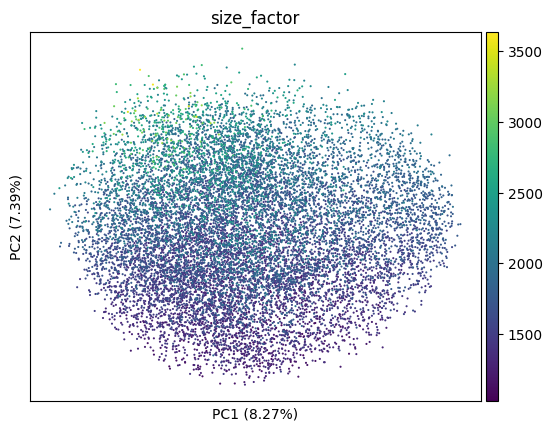

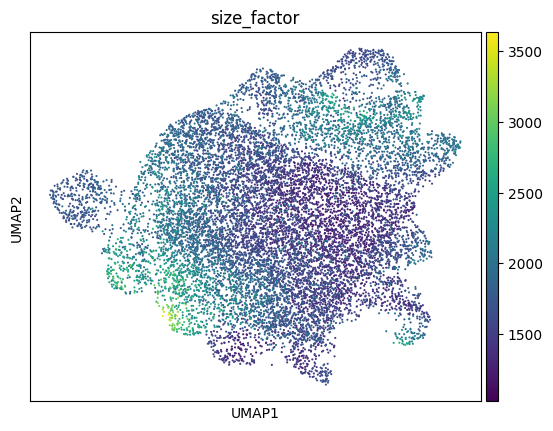

In [283]:
sc.pl.pca(adata, color="size_factor", annotate_var_explained=True)
sc.pl.umap(adata, color="size_factor")

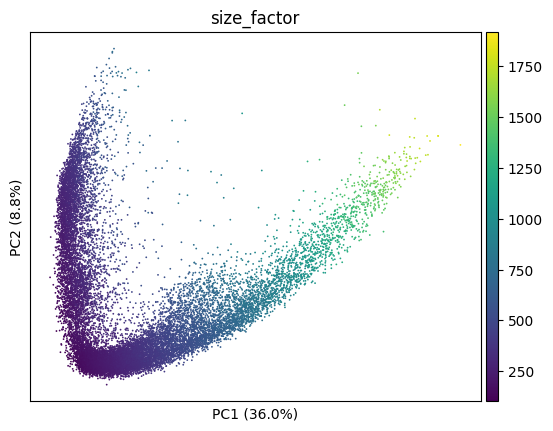

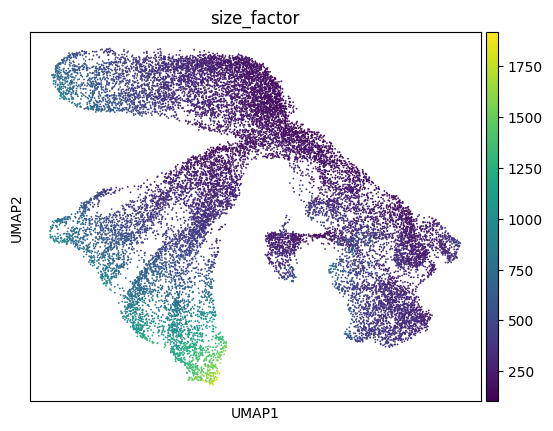

In [284]:
sc.pl.pca(adata_original, color="size_factor",  annotate_var_explained=True)
sc.pl.umap(adata_original, color="size_factor")

In [285]:
for i in generative_model.theta:
    print(i)

tensor(7.1375, device='cuda:0', grad_fn=<UnbindBackward0>)
tensor(7.5591, device='cuda:0', grad_fn=<UnbindBackward0>)
tensor(6.7287, device='cuda:0', grad_fn=<UnbindBackward0>)
tensor(8.1002, device='cuda:0', grad_fn=<UnbindBackward0>)
tensor(8.2226, device='cuda:0', grad_fn=<UnbindBackward0>)
tensor(8.1258, device='cuda:0', grad_fn=<UnbindBackward0>)
tensor(2.5030, device='cuda:0', grad_fn=<UnbindBackward0>)
tensor(8.2508, device='cuda:0', grad_fn=<UnbindBackward0>)
tensor(8.1530, device='cuda:0', grad_fn=<UnbindBackward0>)
tensor(7.1558, device='cuda:0', grad_fn=<UnbindBackward0>)
tensor(7.6596, device='cuda:0', grad_fn=<UnbindBackward0>)
tensor(8.0639, device='cuda:0', grad_fn=<UnbindBackward0>)
tensor(7.0150, device='cuda:0', grad_fn=<UnbindBackward0>)
tensor(8.1525, device='cuda:0', grad_fn=<UnbindBackward0>)
tensor(7.2100, device='cuda:0', grad_fn=<UnbindBackward0>)
tensor(8.6071, device='cuda:0', grad_fn=<UnbindBackward0>)
tensor(8.5643, device='cuda:0', grad_fn=<UnbindBackward0

In [286]:
adata_original.X.sum(1)

matrix([[467.92618],
        [455.06387],
        [875.6751 ],
        ...,
        [274.8106 ],
        [251.62425],
        [220.27817]], dtype=float32)

In [287]:
adata.X.sum(1)

array([2578.7031, 1904.372 , 1617.6099, ..., 1303.2388, 1847.3005,
       1225.9393], dtype=float32)

In [288]:
# for batch in dataloader:
#     x = batch["X_norm"]
#     x_scaled = generative_model.scaler.scale(batch["X_norm"].to(generative_model.device), reverse=False)

In [289]:
X_generated.sum(1)

tensor([16550., 11776.,  9318.,  ...,  4928.,  8423.,  5851.], device='cuda:0')

In [290]:
z_gen.max()

tensor(219.4546, device='cuda:0')

In [291]:
X_generated.sum(1).max()

tensor(24999., device='cuda:0')

In [292]:
adata_original.layers["X_counts"].sum(1).max()

11976.0

**Check hyperparams**

In [293]:
denoising_model = generative_model.denoising_model
denoising_model

MLPTimeStep(
  (embed_time): Sequential(
    (0): Linear(in_features=128, out_features=512, bias=True)
    (1): SiLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): SiLU()
  )
  (embed_size_factor): Sequential(
    (0): Linear(in_features=128, out_features=512, bias=True)
    (1): SiLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): SiLU()
  )
  (net_in): Linear(in_features=2000, out_features=512, bias=True)
  (down_blocks): ModuleList(
    (0): ResnetBlock(
      (net1): Sequential(
        (0): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (1): SiLU()
        (2): Linear(in_features=512, out_features=256, bias=True)
      )
      (cond_proj_gamma): Linear(in_features=512, out_features=256, bias=False)
      (cond_proj_size_factor): Linear(in_features=512, out_features=256, bias=False)
      (net2): Sequential(
        (0): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_s

In [294]:
denoising_model.hidden_dim

128

In [295]:
denoising_model.embedding_dim

128

In [296]:
denoising_model.embed_gamma

True

**Check generated values**

In [297]:
z_gen.min()

tensor(-159.0345, device='cuda:0')

In [298]:
z_gen.max()

tensor(219.4546, device='cuda:0')

In [299]:
X_generated.sum(1)

tensor([16550., 11776.,  9318.,  ...,  4928.,  8423.,  5851.], device='cuda:0')

In [300]:
adata_original.layers["X_counts"].A.sum(1)

array([1382., 1308., 3705., ...,  635.,  536.,  439.], dtype=float32)

In [301]:
X_generated.max(1)

torch.return_types.max(
values=tensor([744., 395., 730.,  ..., 139., 219., 606.], device='cuda:0'),
indices=tensor([ 175, 1017,  658,  ...,   33,  465,  658], device='cuda:0'))

In [302]:
for i in z[0]:
    print(i)

tensor(2.9429, device='cuda:0')
tensor(6., device='cuda:0')
tensor(6., device='cuda:0')
tensor(0., device='cuda:0')
tensor(1.1202, device='cuda:0')
tensor(9., device='cuda:0')
tensor(0.3332, device='cuda:0')
tensor(0., device='cuda:0')
tensor(0., device='cuda:0')
tensor(8., device='cuda:0')
tensor(15., device='cuda:0')
tensor(0., device='cuda:0')
tensor(0., device='cuda:0')
tensor(0., device='cuda:0')
tensor(1.7509, device='cuda:0')
tensor(0., device='cuda:0')
tensor(20.0000, device='cuda:0')
tensor(13.0000, device='cuda:0')
tensor(0., device='cuda:0')
tensor(11., device='cuda:0')
tensor(0., device='cuda:0')
tensor(1.4891, device='cuda:0')
tensor(0., device='cuda:0')
tensor(0., device='cuda:0')
tensor(0., device='cuda:0')
tensor(0.0841, device='cuda:0')
tensor(0., device='cuda:0')
tensor(18., device='cuda:0')
tensor(5.6002, device='cuda:0')
tensor(0., device='cuda:0')
tensor(10.0000, device='cuda:0')
tensor(4.0000, device='cuda:0')
tensor(0., device='cuda:0')
tensor(0.1260, device='cud

In [303]:
for i in X_generated[0]:
    print(i)

tensor(4., device='cuda:0')
tensor(12., device='cuda:0')
tensor(9., device='cuda:0')
tensor(0., device='cuda:0')
tensor(0., device='cuda:0')
tensor(17., device='cuda:0')
tensor(0., device='cuda:0')
tensor(0., device='cuda:0')
tensor(0., device='cuda:0')
tensor(9., device='cuda:0')
tensor(18., device='cuda:0')
tensor(0., device='cuda:0')
tensor(0., device='cuda:0')
tensor(0., device='cuda:0')
tensor(2., device='cuda:0')
tensor(0., device='cuda:0')
tensor(21., device='cuda:0')
tensor(13., device='cuda:0')
tensor(0., device='cuda:0')
tensor(11., device='cuda:0')
tensor(0., device='cuda:0')
tensor(0., device='cuda:0')
tensor(0., device='cuda:0')
tensor(0., device='cuda:0')
tensor(0., device='cuda:0')
tensor(0., device='cuda:0')
tensor(0., device='cuda:0')
tensor(17., device='cuda:0')
tensor(5., device='cuda:0')
tensor(0., device='cuda:0')
tensor(9., device='cuda:0')
tensor(1., device='cuda:0')
tensor(0., device='cuda:0')
tensor(0., device='cuda:0')
tensor(0., device='cuda:0')
tensor(1., de

In [304]:
X_generated.sum(1).mean()

tensor(9276.0791, device='cuda:0')

In [305]:
adata_original.layers["X_counts"].A.max(1)

array([ 68.,  64., 269., ...,  38.,  32.,  13.], dtype=float32)

In [306]:
torch.round(z).sum(1)

tensor([16793., 11778.,  9287.,  ...,  4996.,  8520.,  5745.], device='cuda:0')

In [307]:
X_generated.sum(1)

tensor([16550., 11776.,  9318.,  ...,  4928.,  8423.,  5851.], device='cuda:0')

In [308]:
X_generated.max(1)

torch.return_types.max(
values=tensor([744., 395., 730.,  ..., 139., 219., 606.], device='cuda:0'),
indices=tensor([ 175, 1017,  658,  ...,   33,  465,  658], device='cuda:0'))

In [309]:
z.sum(1).mean()

tensor(9275.7686, device='cuda:0')

In [310]:
2000-torch.count_nonzero(X_generated[0])

tensor(780, device='cuda:0')

In [311]:
2000-torch.count_nonzero(torch.tensor(adata_original.layers["X_counts"].A[0]))

tensor(1597)

In [313]:
for i in z_gen[0]:
    print(i)

tensor(0.7048, device='cuda:0')
tensor(7.9554, device='cuda:0')
tensor(2.6071, device='cuda:0')
tensor(-8.6675, device='cuda:0')
tensor(-0.4579, device='cuda:0')
tensor(7.3992, device='cuda:0')
tensor(-0.4765, device='cuda:0')
tensor(-4.6292, device='cuda:0')
tensor(-5.1902, device='cuda:0')
tensor(3.4499, device='cuda:0')
tensor(6.0077, device='cuda:0')
tensor(-2.4978, device='cuda:0')
tensor(-4.5971, device='cuda:0')
tensor(-4.6680, device='cuda:0')
tensor(0.2575, device='cuda:0')
tensor(-7.1514, device='cuda:0')
tensor(2.0461, device='cuda:0')
tensor(9.8467, device='cuda:0')
tensor(-1.3944, device='cuda:0')
tensor(2.7194, device='cuda:0')
tensor(-6.0949, device='cuda:0')
tensor(-0.1699, device='cuda:0')
tensor(-3.4506, device='cuda:0')
tensor(-3.3393, device='cuda:0')
tensor(-4.0808, device='cuda:0')
tensor(-0.8529, device='cuda:0')
tensor(-2.9965, device='cuda:0')
tensor(8.6078, device='cuda:0')
tensor(0.4714, device='cuda:0')
tensor(-5.7328, device='cuda:0')
tensor(1.5636, device=

In [315]:
z_gen[0].min()

tensor(-19.8462, device='cuda:0')